In [1]:
# pip install imutils

In [2]:
# pip install opencv-python

In [1]:
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt
import pandas as pd

# Preprocess img

In [2]:
def getContours(image, min_area=100, max_area=1000, min_corners=4):

    # Chuyển đổi sang ảnh xám
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Làm mờ ảnh bằng Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Phát hiện cạnh bằng Canny
    edges = cv2.Canny(blurred_image, 100, 500)

    # Làm dày các cạnh bằng phép Dilation
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)

    # Làm mỏng các cạnh bằng phép Erosion
    eroded = cv2.erode(dilated, kernel, iterations=1)

    # Tìm các contours trong ảnh
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Lọc các contours hợp lệ
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < min_area or area > max_area:
            continue

        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        # Tính số lượng cạnh của đối tượng
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        num_corners = len(approx)

        if num_corners >= min_corners:
            filtered_contours.append(contour)

    # Sắp xếp các contours theo diện tích (từ lớn đến nhỏ)
    final_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)

    # Vẽ các contours lên ảnh
    img = image.copy()
    cv2.drawContours(img, final_contours, -1, (0, 255, 0), 2)

    return img, final_contours


In [3]:
def wrapImage(img, points, widthImg, heightImg, pad=0):

    # Chuyển đổi các điểm xác định thành numpy array
    points = np.array(points, dtype=np.float32)

    # Xác định các điểm gốc (điểm chuẩn để biến đổi hình học)
    pts_dst = np.array([
        [0, 0],
        [widthImg - 1, 0],
        [widthImg - 1, heightImg - 1],
        [0, heightImg - 1]
    ], dtype=np.float32)

    # Tính ma trận biến đổi hình học (homography)
    matrix, _ = cv2.findHomography(points, pts_dst)

    # Thực hiện phép biến đổi hình học
    warped_image = cv2.warpPerspective(img, matrix, (widthImg, heightImg))

    # Thêm padding nếu cần
    if pad > 0:
        padded_image = cv2.copyMakeBorder(warped_image, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        return padded_image

    return warped_image


In [4]:
def get4Contour(contours):
    # Tính trung bình tọa độ của các điểm
    center = np.mean(contours, axis=0).reshape(-1, 2)

    # Phân chia các điểm thành hai nhóm: trên và dưới
    top_points = [pt for pt in contours if pt[0][1] < center[0][1]]
    bottom_points = [pt for pt in contours if pt[0][1] >= center[0][1]]

    # Xác định các điểm góc trên và dưới
    top_left = min(top_points, key=lambda p: p[0][0])
    top_right = max(top_points, key=lambda p: p[0][0])
    bottom_left = min(bottom_points, key=lambda p: p[0][0])
    bottom_right = max(bottom_points, key=lambda p: p[0][0])

    # Trả về các điểm góc đã được sắp xếp
    sorted_points = np.array([top_left[0], top_right[0], bottom_right[0], bottom_left[0]], dtype=np.float32)

    return sorted_points

In [5]:
def per_width():
    per_width = [0.876, 0.94]
    per_height = (0.0975, 0.298)
    return per_width, per_height

def per_width_1():
    per_width = (0.727, 0.845)
    per_height = (0.0975, 0.298)
    return per_width, per_height

def per_width_2():
    per_width = (0.055, 0.925)
    per_height = (0.326, 0.945)
    return per_width, per_height

# Get key and Infor

In [6]:
def read_answer_key(answer_key_path):
    key = pd.read_excel(answer_key_path)
    return key['Answer']

In [54]:
def get_In4code(img, num_columns, num_rows, thresh_value=150):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, thresh_value, 255, cv2.THRESH_BINARY)
    
    column_width = thresh.shape[1] // num_columns
    row_idx = [int(i * (thresh.shape[0] / num_rows)) for i in range(num_rows + 1)]
    
    code = ""
    for i in range(num_columns):
        col = thresh[:, i * column_width:(i + 1) * column_width]
        min = float('inf')
        num = None
        for j in range(num_rows):
            s, e = row_idx[j], row_idx[j + 1]
            mean = np.mean(col[s:e,:])
            if mean < min:
                min = mean
                num = j
            else:
                code += '-'
        code += str(num)
    return code

# Blobs Detector Algorithm

In [63]:
def get_kp(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(gray_img, (5,5), 0)
    thresh = cv2.threshold(blur_img, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # Cài đặt thông số cho bộ phát hiện blob
    params = cv2.SimpleBlobDetector_Params()

    # Thay đổi các ngưỡng (threshold)
    params.minThreshold = 10
    params.maxThreshold = 150

    # Lọc theo diện tích (Area)
    params.filterByArea = True
    params.minArea = 100  # Điều chỉnh để phù hợp với kích thước các chấm đen trên phiếu
    params.maxArea = 1000

    # Lọc theo độ tròn (Circularity)
    params.filterByCircularity = True
    params.minCircularity = 0.7  # Những chấm đen có hình tròn

    # Lọc theo độ lồi (Convexity)
    params.filterByConvexity = True
    params.minConvexity = 0.87

    # Lọc theo độ quán tính (Inertia)
    params.filterByInertia = True
    params.minInertiaRatio = 0.01

    # Tạo bộ phát hiện blob với các tham số đã cài đặt
    detector = cv2.SimpleBlobDetector_create(params)

    # Phát hiện các blob
    keypoints = detector.detect(gray_img)
    im_with_keypoints = cv2.drawKeypoints(gray_img, keypoints, np.array([]), (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#      print(keypoints[0].pt)
#      Hiển thị hình ảnh đã phát hiện blob
#     plt.figure(figsize=(10, 10))
#     plt.imshow(im_with_keypoints, cmap='gray')
#     plt.title("Phát hiện các chấm đen trong ảnh")
#     plt.axis('off')  # Ẩn trục để hiển thị tốt hơn
#     plt.show()
    return keypoints

def get_ans(image_ans, key, thresh_value=150, top_offset=9, bottom_offset=7, left_offset=43, right_offset=20):
    gray = image_ans
    column_width = gray.shape[1] // 4  # 4 cột cho các đáp án A, B, C, D
    row_height = gray.shape[0] // 6  # 6 hàng cho các câu hỏi
    char_ans = ['A', 'B', 'C', 'D']
    answers = []
    question_index = 0  # Đếm thứ tự câu hỏi
    flag = False
    for col in range(4):
        # Tách từng cột đáp án
        column_img = gray[:, col * column_width:(col + 1) * column_width]
        for row in range(6):
            # Tách từng hàng câu hỏi
            start_y = row * row_height
            end_y = (row + 1) * row_height
            row_img = column_img[start_y:end_y, left_offset:-right_offset]
            row_img = row_img[top_offset:-bottom_offset, :]  # Cắt phần trên của hàng
            # Chia nhỏ từng câu hỏi trong hàng
            question_height = row_img.shape[0] // 5
            for q in range(5):
                question_img = row_img[q * question_height:(q + 1) * question_height, :]
                answer_img = question_img # Lấy phần đáp án
                bubble_width = answer_img.shape[1] // 4  # 4 lựa chọn A, B, C, D
                # Phát hiện các blob (chấm đen) trong đáp án
                blobs = get_kp(answer_img)
                # Nếu phát hiện có blob trong phần đáp án nào đó
                if blobs:
                    for blob in blobs:
                        # Tìm đáp án nào được chọn dựa vào vị trí của blob
                        for i in range(4):
                            if blob.pt[0] >= i * bubble_width and blob.pt[0] < (i + 1) * bubble_width:
                                ans = char_ans[i]
                                answers.append(ans)
                else:
                    answers.append('-')
                question_index += 1
                if question_index == len(key):
                    flag = True
                    break
            if flag:
                break
        if flag:
            break
    return answers

In [64]:
def get_score(ans, key):
    score=0
    lst_false=[]
    true_question=0
    for i in range(len(key)):
        if ans[i] == key[i]:
            score+=1
        else:
            lst_false.append(i+1)
    percent=f"{score}/{len(key)}"
    return percent, lst_false

In [65]:
def display(std, t_code, score, lst_f):
    print(f"Mã sinh viên:{std}")
    print(f"Mã đề thi:{t_code}")
    print(f"Số câu đúng:{score}")
    print(f"Những câu sai:{lst_f}")

# Read img

In [66]:
org_img = cv2.imread('test_case2.png')
gray_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2GRAY)
blur_img = cv2.GaussianBlur(gray_img, (5,5), 0)
thresh = cv2.threshold(gray_img, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

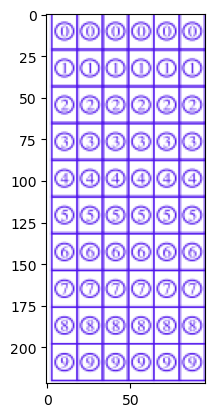

In [67]:
# student_code = (0.724, 0.845, 0.1, 0.298)
height, width = org_img.shape[:2]
img_std = org_img[int(0.1 * height):int(0.298 * height), int(0.724 * width):int(0.845 * width)]

# test_code = (0.873, 0.938, 0.1, 0.298)
height, width = org_img.shape[:2]
img_testCode = org_img[int(0.1 * height):int(0.298 * height), int(0.873 * width):int(0.938 * width)]

# answers = (0.04, 0.942, 0.325, 0.945)
height, width = org_img.shape[:2]
img_ans = org_img[int(0.325 * height):int(0.945 * height), int(0.04 * width):int(0.942 * width)]
plt.imshow(img_std)

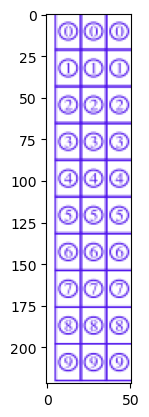

In [68]:
plt.imshow(img_testCode)

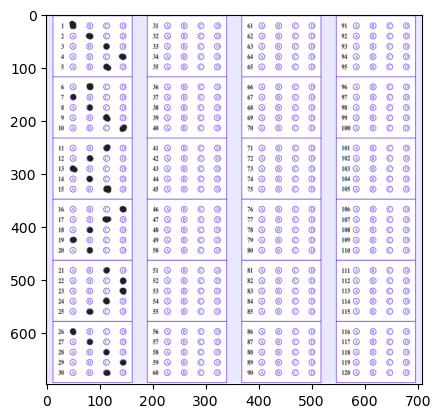

In [69]:
plt.imshow(img_ans)

In [70]:
key_test1=['A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B']

key_test2=['A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C', 'D', 'C', 'B']

key_test3=['A', 'B', 'C', 'D', 'C', 'B', 'A', 'B', 'C', 'D', 'C', 'B',
    'A', 'B', 'C']

In [71]:
answer_key_path = 'DapAn.xlsx'
answer_key = read_answer_key(answer_key_path)

In [72]:
# key_test1 = list(answer_key)

In [73]:
# key_test1

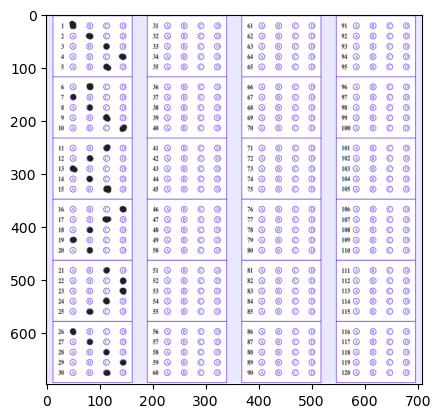

In [74]:
test_code = get_In4code(img_testCode, 3, 10)
std = get_In4code(img_std, 6, 10)
ans = get_ans(img_ans, key_test2)
plt.imshow(img_ans)

In [75]:
ans

['A',
 'B',
 'C',
 'D',
 'C',
 'B',
 'A',
 'B',
 'C',
 'D',
 'C',
 'B',
 'A',
 'B',
 'C',
 'D',
 'C',
 'B',
 'A',
 'B',
 'C',
 'D',
 'D',
 'C',
 'B',
 'A',
 'B',
 'C',
 'D',
 'C']

In [76]:
len(ans)

30

In [77]:
score, lst = get_score(ans, key_test2)

In [78]:
display(std, test_code, score, lst)

Mã sinh viên:--------1-------4-------4------4--------1-------4
Mã đề thi:-------4-------4--------1
Số câu đúng:22/30
Những câu sai:[23, 24, 25, 26, 27, 28, 29, 30]


# Giao diện